In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import collections

from tensor2tensor import models
from tensor2tensor import problems
from tensor2tensor.layers import common_layers
from tensor2tensor.utils import trainer_lib
from tensor2tensor.utils import t2t_model
from tensor2tensor.utils import registry
from tensor2tensor.utils import metrics

# Enable TF Eager execution
from tensorflow.contrib.eager.python import tfe
tfe.enable_eager_execution()

# Other setup
Modes = tf.estimator.ModeKeys

# Setup some directories
data_dir = os.path.expanduser("~/t2t/data")
tmp_dir = os.path.expanduser("~/t2t/tmp")
train_dir = os.path.expanduser("~/t2t/train")
checkpoint_dir = os.path.expanduser("~/t2t/checkpoints")
tf.gfile.MakeDirs(data_dir)
tf.gfile.MakeDirs(tmp_dir)
tf.gfile.MakeDirs(train_dir)
tf.gfile.MakeDirs(checkpoint_dir)
gs_data_dir = "gs://tensor2tensor-data"
gs_ckpt_dir = "gs://tensor2tensor-checkpoints/"

In [2]:
# A Problem is a dataset together with some fixed pre-processing.
# It could be a translation dataset with a specific tokenization,
# or an image dataset with a specific resolution.
#
# There are many problems available in Tensor2Tensor
problems.available()

['algorithmic_addition_binary40',
 'algorithmic_addition_decimal40',
 'algorithmic_cipher_shift200',
 'algorithmic_cipher_shift5',
 'algorithmic_cipher_vigenere200',
 'algorithmic_cipher_vigenere5',
 'algorithmic_identity_binary40',
 'algorithmic_identity_decimal40',
 'algorithmic_multiplication_binary40',
 'algorithmic_multiplication_decimal40',
 'algorithmic_reverse_binary40',
 'algorithmic_reverse_binary40_test',
 'algorithmic_reverse_decimal40',
 'algorithmic_reverse_nlplike32k',
 'algorithmic_reverse_nlplike8k',
 'algorithmic_shift_decimal40',
 'audio_timit_characters_tune',
 'audio_timit_tokens8k_test',
 'audio_timit_tokens8k_tune',
 'gym_pong_random5k',
 'gym_pong_trajectories_from_policy',
 'image_celeba',
 'image_cifar10',
 'image_cifar100',
 'image_cifar100_plain',
 'image_cifar100_plain8',
 'image_cifar100_plain_gen',
 'image_cifar100_tune',
 'image_cifar10_plain',
 'image_cifar10_plain8',
 'image_cifar10_plain_gen',
 'image_cifar10_tune',
 'image_fashion_mnist',
 'image_fsn

In [3]:
# Fetch the MNIST problem
mnist_problem = problems.problem("image_mnist")
# The generate_data method of a problem will download data and process it into
# a standard format ready for training and evaluation.
mnist_problem.generate_data(data_dir, tmp_dir)

INFO:tensorflow:Not downloading, file already found: /home/mtdesta/t2t/tmp/train-images-idx3-ubyte.gz


[2018-04-03 13:19:11,057] Not downloading, file already found: /home/mtdesta/t2t/tmp/train-images-idx3-ubyte.gz


INFO:tensorflow:Not downloading, file already found: /home/mtdesta/t2t/tmp/train-labels-idx1-ubyte.gz


[2018-04-03 13:19:11,059] Not downloading, file already found: /home/mtdesta/t2t/tmp/train-labels-idx1-ubyte.gz


INFO:tensorflow:Not downloading, file already found: /home/mtdesta/t2t/tmp/t10k-images-idx3-ubyte.gz


[2018-04-03 13:19:11,060] Not downloading, file already found: /home/mtdesta/t2t/tmp/t10k-images-idx3-ubyte.gz


INFO:tensorflow:Not downloading, file already found: /home/mtdesta/t2t/tmp/t10k-labels-idx1-ubyte.gz


[2018-04-03 13:19:11,062] Not downloading, file already found: /home/mtdesta/t2t/tmp/t10k-labels-idx1-ubyte.gz


INFO:tensorflow:Not downloading, file already found: /home/mtdesta/t2t/tmp/train-images-idx3-ubyte.gz


[2018-04-03 13:19:11,429] Not downloading, file already found: /home/mtdesta/t2t/tmp/train-images-idx3-ubyte.gz


INFO:tensorflow:Not downloading, file already found: /home/mtdesta/t2t/tmp/train-labels-idx1-ubyte.gz


[2018-04-03 13:19:11,431] Not downloading, file already found: /home/mtdesta/t2t/tmp/train-labels-idx1-ubyte.gz


INFO:tensorflow:Not downloading, file already found: /home/mtdesta/t2t/tmp/t10k-images-idx3-ubyte.gz


[2018-04-03 13:19:11,433] Not downloading, file already found: /home/mtdesta/t2t/tmp/t10k-images-idx3-ubyte.gz


INFO:tensorflow:Not downloading, file already found: /home/mtdesta/t2t/tmp/t10k-labels-idx1-ubyte.gz


[2018-04-03 13:19:11,434] Not downloading, file already found: /home/mtdesta/t2t/tmp/t10k-labels-idx1-ubyte.gz


INFO:tensorflow:Skipping generator because outputs files exist


[2018-04-03 13:19:11,483] Skipping generator because outputs files exist


INFO:tensorflow:Skipping generator because outputs files exist


[2018-04-03 13:19:11,484] Skipping generator because outputs files exist


INFO:tensorflow:Skipping shuffle because output files exist


[2018-04-03 13:19:11,486] Skipping shuffle because output files exist


INFO:tensorflow:Reading data files from /home/mtdesta/t2t/data/image_mnist-train*


[2018-04-03 13:19:11,508] Reading data files from /home/mtdesta/t2t/data/image_mnist-train*


INFO:tensorflow:partition: 0 num_data_files: 10


[2018-04-03 13:19:11,511] partition: 0 num_data_files: 10


Label: 7


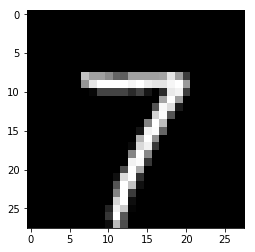

In [4]:
# Now let's see the training MNIST data as Tensors.
mnist_example = tfe.Iterator(mnist_problem.dataset(Modes.TRAIN, data_dir)).next()
image = mnist_example["inputs"]
label = mnist_example["targets"]

plt.imshow(image.numpy()[:, :, 0].astype(np.float32), cmap=plt.get_cmap('gray'))
print("Label: %d" % label.numpy())

In [5]:
# Create your own model

class MySimpleModel(t2t_model.T2TModel):

  def body(self, features):
    inputs = features["inputs"]
    filters = self.hparams.hidden_size
    h1 = tf.layers.conv2d(inputs, filters,
                          kernel_size=(5, 5), strides=(2, 2))
    h2 = tf.layers.conv2d(tf.nn.relu(h1), filters,
                          kernel_size=(5, 5), strides=(2, 2))
    return tf.layers.conv2d(tf.nn.relu(h2), filters,
                            kernel_size=(3, 3))

hparams = trainer_lib.create_hparams("basic_1", data_dir=data_dir, problem_name="image_mnist")
hparams.hidden_size = 64
model = MySimpleModel(hparams, Modes.TRAIN)

[('batch_size_multiplier', 4), ('input_modality', {'inputs': ('image', 256)}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', ('class_label', 10)), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Setting T2TModel mode to 'train'


[2018-04-03 13:19:12,422] Setting T2TModel mode to 'train'


In [6]:
# Prepare for the training loop

# In Eager mode, opt.minimize must be passed a loss function wrapped with
# implicit_value_and_gradients
@tfe.implicit_value_and_gradients
def loss_fn(features):
  _, losses = model(features)
  return losses["training"]

# Setup the training data
BATCH_SIZE = 128
mnist_train_dataset = mnist_problem.dataset(Modes.TRAIN, data_dir)
mnist_train_dataset = mnist_train_dataset.repeat(None).batch(BATCH_SIZE)

optimizer = tf.train.AdamOptimizer()

INFO:tensorflow:Reading data files from /home/mtdesta/t2t/data/image_mnist-train*


[2018-04-03 13:19:12,472] Reading data files from /home/mtdesta/t2t/data/image_mnist-train*


INFO:tensorflow:partition: 0 num_data_files: 10


[2018-04-03 13:19:12,475] partition: 0 num_data_files: 10


In [7]:
print(mnist_train_dataset)

<BatchDataset shapes: {targets: (?, 1), inputs: (?, 28, 28, 1)}, types: {targets: tf.int64, inputs: tf.float32}>


In [8]:
# Train
NUM_STEPS = 500

for count, example in enumerate(tfe.Iterator(mnist_train_dataset)):
  example["targets"] = tf.reshape(example["targets"], [BATCH_SIZE, 1, 1, 1])  # Make it 4D.
  loss, gv = loss_fn(example)
  optimizer.apply_gradients(gv)

  if count % 50 == 0:
    print("Step: %d, Loss: %.3f" % (count, loss.numpy()))
  if count >= NUM_STEPS:
    break

INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:12,682] Using variable initializer: orthogonal


INFO:tensorflow:Transforming feature 'inputs' with image_modality.bottom


[2018-04-03 13:19:12,685] Transforming feature 'inputs' with image_modality.bottom


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Transforming 'targets' with class_label_modality_10_64.targets_bottom


[2018-04-03 13:19:12,686] Transforming 'targets' with class_label_modality_10_64.targets_bottom


INFO:tensorflow:Building model body


[2018-04-03 13:19:12,687] Building model body


INFO:tensorflow:Transforming body output with class_label_modality_10_64.top


[2018-04-03 13:19:12,712] Transforming body output with class_label_modality_10_64.top


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



[2018-04-03 13:19:12,890] From /home/mtdesta/tensorflow_1.6/lib/python3.5/site-packages/tensor2tensor/layers/common_layers.py:1717: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



Step: 0, Loss: 6.111
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:12,941] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:12,990] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:13,036] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:13,083] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:13,131] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:13,179] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:13,228] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:13,275] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:13,322] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:13,369] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:13,419] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:13,465] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:13,513] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:13,560] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:13,609] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:13,653] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:13,700] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:13,748] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:13,794] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:13,842] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:13,887] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:13,931] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:13,978] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:14,025] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:14,071] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:14,117] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:14,168] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:14,214] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:14,261] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:14,309] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:14,355] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:14,401] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:14,446] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:14,493] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:14,540] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:14,586] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:14,634] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:14,681] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:14,731] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:14,778] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:14,823] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:14,869] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:14,918] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:14,967] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:15,014] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:15,062] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:15,109] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:15,154] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:15,200] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:15,250] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
Step: 50, Loss: 0.723
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:15,298] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:15,347] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:15,393] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:15,439] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:15,487] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:15,535] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:15,582] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:15,627] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:15,674] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:15,719] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:15,766] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:15,813] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:15,859] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:15,906] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:15,952] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:15,999] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:16,047] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:16,095] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:16,142] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:16,189] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:16,235] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:16,281] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:16,328] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:16,375] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:16,423] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:16,468] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:16,515] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:16,560] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:16,609] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:16,656] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:16,700] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:16,746] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:16,793] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:16,842] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:16,896] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:16,940] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:16,987] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:17,033] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:17,079] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:17,134] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:17,180] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:17,226] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:17,272] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:17,319] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:17,363] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:17,409] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:17,458] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:17,506] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:17,552] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:17,598] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
Step: 100, Loss: 0.568
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:17,644] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:17,690] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:17,736] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:17,783] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:17,830] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:17,875] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:17,922] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:17,968] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:18,017] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:18,066] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:18,114] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:18,161] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:18,206] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:18,254] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:18,300] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:18,347] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:18,394] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:18,439] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:18,487] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:18,531] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:18,579] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:18,625] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:18,673] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:18,720] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:18,769] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:18,814] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:18,861] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:18,909] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:18,956] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:19,002] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:19,048] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:19,095] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:19,140] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:19,189] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:19,234] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:19,280] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:19,326] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:19,373] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:19,419] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:19,467] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:19,513] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:19,559] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:19,604] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:19,652] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:19,697] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:19,744] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:19,790] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:19,835] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:19,882] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:19,927] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
Step: 150, Loss: 0.503
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:19,974] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:20,021] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:20,067] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:20,113] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:20,161] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:20,210] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:20,257] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:20,303] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:20,349] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:20,398] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:20,443] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:20,495] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:20,543] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:20,590] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:20,637] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:20,685] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:20,733] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:20,779] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:20,825] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:20,873] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:20,917] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:20,964] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:21,009] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:21,056] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:21,101] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:21,147] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:21,194] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:21,240] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:21,290] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:21,337] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:21,381] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:21,429] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:21,475] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:21,520] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:21,566] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:21,613] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:21,658] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:21,704] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:21,751] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:21,800] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:21,846] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:21,893] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:21,940] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:21,988] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:22,035] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:22,080] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:22,126] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:22,174] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:22,221] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:22,275] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
Step: 200, Loss: 0.402
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:22,320] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:22,367] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:22,414] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:22,459] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:22,507] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:22,555] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:22,603] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:22,652] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:22,696] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:22,744] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:22,792] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:22,837] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:22,884] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:22,932] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:22,978] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:23,024] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:23,075] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:23,122] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:23,170] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:23,218] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:23,264] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:23,312] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:23,356] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:23,403] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:23,449] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:23,495] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:23,546] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:23,590] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:23,638] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:23,685] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:23,730] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:23,778] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:23,825] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:23,871] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:23,917] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:23,963] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:24,009] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:24,056] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:24,103] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:24,149] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:24,195] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:24,243] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:24,288] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:24,336] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:24,381] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:24,428] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:24,475] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:24,521] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:24,569] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:24,616] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
Step: 250, Loss: 0.531
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:24,662] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:24,709] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:24,755] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:24,802] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:24,848] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:24,893] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:24,941] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:24,986] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:25,033] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:25,081] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:25,128] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:25,176] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:25,223] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:25,270] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:25,317] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:25,363] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:25,410] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:25,457] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:25,507] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:25,551] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:25,599] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:25,647] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:25,691] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:25,739] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:25,786] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:25,832] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:25,878] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:25,924] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:25,973] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:26,020] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:26,071] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:26,117] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:26,165] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:26,217] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:26,262] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:26,309] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:26,356] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:26,407] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:26,453] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:26,501] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:26,547] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:26,592] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:26,637] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:26,684] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:26,731] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:26,776] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:26,822] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:26,869] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:26,916] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:26,962] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
Step: 300, Loss: 0.519
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:27,014] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:27,059] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:27,105] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:27,152] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:27,199] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:27,247] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:27,293] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:27,339] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:27,386] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:27,434] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:27,480] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:27,524] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:27,572] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:27,619] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:27,668] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:27,716] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:27,765] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:27,811] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:27,858] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:27,904] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:27,951] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:27,998] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:28,044] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:28,092] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:28,143] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:28,191] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:28,237] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:28,284] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:28,332] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:28,377] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:28,423] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:28,469] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:28,520] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:28,566] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:28,613] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:28,659] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:28,705] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:28,752] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:28,796] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:28,842] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:28,888] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:28,933] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:28,981] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:29,030] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:29,077] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:29,123] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:29,172] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:29,221] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:29,269] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:29,314] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
Step: 350, Loss: 0.475
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:29,363] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:29,407] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:29,455] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:29,501] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:29,550] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:29,597] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:29,644] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:29,690] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:29,741] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:29,785] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:29,832] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:29,879] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:29,927] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:29,971] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:30,019] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:30,065] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:30,111] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:30,158] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:30,205] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:30,251] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:30,299] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:30,344] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:30,392] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:30,441] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:30,486] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:30,532] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:30,578] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:30,622] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:30,671] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:30,718] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:30,765] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:30,811] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:30,857] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:30,904] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:30,950] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:30,995] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:31,042] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:31,088] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:31,134] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:31,180] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:31,226] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:31,272] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:31,319] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:31,366] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:31,413] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:31,458] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:31,505] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:31,551] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:31,598] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:31,644] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
Step: 400, Loss: 0.335
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:31,690] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:31,735] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:31,781] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:31,826] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:31,871] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:31,919] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:31,964] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:32,012] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:32,058] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:32,105] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:32,153] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:32,200] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:32,246] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:32,293] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:32,338] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:32,389] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:32,434] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:32,480] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:32,528] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:32,573] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:32,619] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:32,665] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:32,711] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:32,756] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:32,803] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:32,850] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:32,898] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:32,942] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:32,987] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:33,033] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:33,084] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:33,134] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:33,182] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:33,230] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:33,276] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:33,322] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:33,368] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:33,418] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:33,464] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:33,512] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:33,559] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:33,605] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:33,651] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:33,697] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:33,744] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:33,790] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:33,835] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:33,882] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:33,931] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:33,978] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
Step: 450, Loss: 0.252
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:34,022] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:34,068] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:34,116] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:34,165] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:34,213] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:34,260] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:34,307] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:34,355] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:34,402] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:34,449] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:34,496] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:34,540] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:34,586] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:34,632] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:34,680] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:34,729] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:34,776] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:34,840] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:34,884] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:34,931] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:34,975] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:35,021] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:35,069] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:35,117] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:35,167] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:35,212] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:35,257] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:35,305] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:35,354] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:35,403] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:35,449] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:35,495] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:35,542] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:35,589] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:35,636] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:35,682] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:35,728] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:35,775] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:35,823] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:35,871] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:35,916] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:35,964] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:36,011] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:36,059] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:36,106] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:36,151] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:36,198] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:36,245] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:36,293] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:36,342] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
Step: 500, Loss: 0.381


In [9]:
model.set_mode(Modes.EVAL)
mnist_eval_dataset = mnist_problem.dataset(Modes.EVAL, data_dir)

# Create eval metric accumulators for accuracy (ACC) and accuracy in
# top 5 (ACC_TOP5)
metrics_accum, metrics_result = metrics.create_eager_metrics(
    [metrics.Metrics.ACC, metrics.Metrics.ACC_TOP5])

for count, example in enumerate(tfe.Iterator(mnist_eval_dataset)):
  if count >= 200:
    break

  # Make the inputs and targets 4D
  example["inputs"] = tf.reshape(example["inputs"], [1, 28, 28, 1])
  example["targets"] = tf.reshape(example["targets"], [1, 1, 1, 1])

  # Call the model
  predictions, _ = model(example)

  # Compute and accumulate metrics
  metrics_accum(predictions, example["targets"])

# Print out the averaged metric values on the eval data
for name, val in metrics_result().items():
  print("%s: %.2f" % (name, val))

INFO:tensorflow:Setting T2TModel mode to 'eval'


[2018-04-03 13:19:36,398] Setting T2TModel mode to 'eval'


INFO:tensorflow:Setting hparams.layer_prepostprocess_dropout to 0.0


[2018-04-03 13:19:36,400] Setting hparams.layer_prepostprocess_dropout to 0.0


INFO:tensorflow:Setting hparams.dropout to 0.0


[2018-04-03 13:19:36,400] Setting hparams.dropout to 0.0


INFO:tensorflow:Setting hparams.symbol_dropout to 0.0


[2018-04-03 13:19:36,401] Setting hparams.symbol_dropout to 0.0


INFO:tensorflow:Reading data files from /home/mtdesta/t2t/data/image_mnist-dev*


[2018-04-03 13:19:36,402] Reading data files from /home/mtdesta/t2t/data/image_mnist-dev*


INFO:tensorflow:partition: 0 num_data_files: 1


[2018-04-03 13:19:36,412] partition: 0 num_data_files: 1


INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:36,497] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:36,513] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:36,525] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:36,539] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:36,552] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:36,564] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:36,577] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:36,589] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:36,602] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:36,615] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:36,627] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:36,639] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:36,651] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:36,663] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:36,675] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:36,687] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:36,700] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:36,712] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:36,724] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:36,736] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:36,748] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:36,760] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:36,777] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:36,789] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:36,802] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:36,814] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:36,827] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:36,840] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:36,852] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:36,863] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:36,877] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:36,888] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:36,901] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:36,913] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:36,926] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:36,938] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:36,951] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:36,962] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:36,977] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:36,990] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,003] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,015] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,028] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,040] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,052] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,064] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,076] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,088] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,101] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,113] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,126] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,138] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,150] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,162] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,174] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,186] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,199] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,211] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,224] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,236] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,249] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,261] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,274] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,286] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,298] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,311] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,323] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,335] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,348] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,361] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,373] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,385] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,398] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,409] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,421] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,433] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,445] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,457] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,469] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,481] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,493] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,506] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,518] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,530] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,543] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,555] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,568] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,580] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,593] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,605] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,617] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,630] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,642] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,654] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,666] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,678] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,691] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,704] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,717] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,729] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,741] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,753] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,764] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,777] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,789] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,802] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,813] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,825] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,837] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,850] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,862] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,874] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,887] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,900] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,912] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,925] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,937] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,949] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,961] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,973] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:37,988] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,000] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,012] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,024] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,037] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,049] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,061] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,073] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,086] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,098] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,110] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,123] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,135] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,147] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,159] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,171] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,184] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,196] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,208] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,220] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,233] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,245] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,257] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,269] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,283] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,295] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,307] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,319] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,332] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,344] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,356] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,368] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,381] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,393] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,405] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,417] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,429] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,441] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,454] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,466] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,478] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,492] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,504] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,516] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,528] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,540] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,553] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,565] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,578] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,590] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,602] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,614] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,626] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,638] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,650] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,663] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,676] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,688] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,700] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,712] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,724] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,736] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,748] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,761] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,773] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,786] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,798] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,810] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,822] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,834] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,847] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,859] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,872] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,884] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,896] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,908] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,920] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,933] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,944] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
INFO:tensorflow:Using variable initializer: orthogonal


[2018-04-03 13:19:38,957] Using variable initializer: orthogonal


[('batch_size_multiplier', 4), ('input_modality', {'inputs': <tensor2tensor.layers.modalities.ImageModality object at 0x7fa8627e7940>}), ('input_space_id', 25), ('loss_multiplier', 3.0), ('stop_at_eos', False), ('target_modality', <tensor2tensor.layers.modalities.ClassLabelModality object at 0x7fa8627e7780>), ('target_space_id', 1), ('vocabulary', {'targets': <tensor2tensor.data_generators.text_encoder.ClassLabelEncoder object at 0x7fa8627e7198>, 'inputs': <tensor2tensor.data_generators.text_encoder.ImageEncoder object at 0x7fa8626ed7b8>}), ('was_copy', False), ('was_reversed', False)]
accuracy: 0.98
accuracy_top5: 1.00
